In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


In [35]:
# Load Auto MPG dataset

auto = fetch_openml(name="autoMpg", version=1, as_frame=True)
df = auto.frame.copy()

# Handle missing values in horsepower (NaN values)
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')
df = df.dropna()  # Drop rows with NaN

print(f"Dataset shape after removing NaN: {df.shape}")
display(df.head(5))
display(df.describe(include="all"))


Dataset shape after removing NaN: (392, 8)


,cylinders,displacement,horsepower,weight,acceleration,model,origin,class
0,8,307.0,130.0,3504,12.0,70,1,18.0
1,8,350.0,165.0,3693,11.5,70,1,15.0
2,8,318.0,150.0,3436,11.0,70,1,18.0
3,8,304.0,150.0,3433,12.0,70,1,16.0
4,8,302.0,140.0,3449,10.5,70,1,17.0


,cylinders,displacement,horsepower,weight,acceleration,model,origin,class
count,392,392.000000,392.000000,392.000000,392.000000,392,392,392.000000
unique,5,NaN,NaN,NaN,NaN,13,3,NaN
top,4,NaN,NaN,NaN,NaN,73,1,NaN
freq,199,NaN,NaN,NaN,NaN,40,245,NaN
mean,NaN,194.411990,104.469388,2977.584184,15.541327,NaN,NaN,23.445918
std,NaN,104.644004,38.491160,849.402560,2.758864,NaN,NaN,7.805007
min,NaN,68.000000,46.000000,1613.000000,8.000000,NaN,NaN,9.000000
25%,NaN,105.000000,75.000000,2225.250000,13.775000,NaN,NaN,17.000000
50%,NaN,151.000000,93.500000,2803.500000,15.500000,NaN,NaN,22.750000
75%,NaN,275.750000,126.000000,3614.750000,17.025000,NaN,NaN,29.000000


In [36]:
y = df["class"]
x = df.drop(columns=["class"])

print("x shape:", x.shape)
print("y shape:", y.shape)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42 )

x_train = x_train.to_numpy().astype(np.float32)
x_test  = x_test.to_numpy().astype(np.float32)
y_train = y_train.to_numpy().reshape(-1,1).astype(np.float32)
y_test  = y_test.to_numpy().reshape(-1,1).astype(np.float32)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x shape: (392, 7)
y shape: (392,)
x_train shape: (313, 7)
y_train shape: (313, 1)


In [37]:
def split_train_val(X, y, val_ratio=0.2, seed=42):
    rng = np.random.default_rng(seed)
    idx = np.arange(X.shape[0])
    rng.shuffle(idx)
    n_val = int(X.shape[0] * val_ratio)
    val_idx = idx[:n_val]
    tr_idx = idx[n_val:]
    return X[tr_idx], y[tr_idx], X[val_idx], y[val_idx]

# split train -> train_sub + val
x_tr, y_tr, x_val, y_val = split_train_val(x_train, y_train, val_ratio=0.2, seed=42)
print("Train_sub:", x_tr.shape, y_tr.shape)
print("Val      :", x_val.shape, y_val.shape)
print("Test     :", x_test.shape, y_test.shape)

# standardize (fit on train_sub only)
mu = x_tr.mean(axis=0, keepdims=True)
sigma = x_tr.std(axis=0, keepdims=True) + 1e-8

x_tr_s   = (x_tr   - mu) / sigma
x_val_s  = (x_val  - mu) / sigma
x_test_s = (x_test - mu) / sigma


Train_sub: (251, 7) (251, 1)
Val      : (62, 7) (62, 1)
Test     : (79, 7) (79, 1)


In [38]:
# Utility functions: activation, loss, data batching

def relu(z):
    return np.maximum(0.0, z)

def relu_backward(dout, z):
    return dout * (z > 0.0)

def mse_loss(y_hat, y):
    return np.mean((y_hat - y) ** 2)

def mse_grad(y_hat, y):
    B = y.shape[0]
    return (2.0 / B) * (y_hat - y)

def make_batches(X, y, batch_size=32, shuffle=True, seed=None):
    n = X.shape[0]
    idx = np.arange(n)
    if shuffle:
        rng = np.random.default_rng(seed)
        rng.shuffle(idx)
    for start in range(0, n, batch_size):
        b = idx[start:start+batch_size]
        yield X[b], y[b]


In [39]:
# Model 1: Linear Regression with SGD

class LinearRegressionSGD:
    def __init__(self, d_in, seed=42):
        rng = np.random.default_rng(seed)
        self.W = rng.normal(0.0, 0.01, size=(d_in, 1)).astype(np.float32)
        self.b = np.zeros((1, 1), dtype=np.float32)

    def forward(self, X):
        return X @ self.W + self.b

    def train_step(self, Xb, yb, lr=0.1):
        y_hat = self.forward(Xb)
        loss = mse_loss(y_hat, yb)
        
        dY = mse_grad(y_hat, yb)
        dW = Xb.T @ dY
        db = np.sum(dY, axis=0, keepdims=True)
        
        self.W -= lr * dW
        self.b -= lr * db
        return float(loss)

    def predict(self, X):
        return self.forward(X)


In [40]:
# Model 2: MLP Regressor (2 hidden layers with ReLU)

class MLPRegressor:
    def __init__(self, d_in, h1=64, h2=64, seed=42):
        rng = np.random.default_rng(seed)
        
        # He initialization for ReLU
        def he(shape, fan_in):
            scale = np.sqrt(2.0 / fan_in)
            return rng.normal(0.0, scale, size=shape).astype(np.float32)
        
        self.W1 = he((d_in, h1), d_in)
        self.b1 = np.zeros((1, h1), dtype=np.float32)
        
        self.W2 = he((h1, h2), h1)
        self.b2 = np.zeros((1, h2), dtype=np.float32)
        
        self.W3 = he((h2, 1), h2)
        self.b3 = np.zeros((1, 1), dtype=np.float32)
        
        self.cache = {}
    
    def forward(self, X):
        z1 = X @ self.W1 + self.b1
        a1 = relu(z1)
        
        z2 = a1 @ self.W2 + self.b2
        a2 = relu(z2)
        
        y_hat = a2 @ self.W3 + self.b3
        
        self.cache = {"X": X, "z1": z1, "a1": a1, "z2": z2, "a2": a2, "y_hat": y_hat}
        return y_hat
    
    def backward(self, y, lr=0.003):
        X = self.cache["X"]
        z1 = self.cache["z1"]
        a1 = self.cache["a1"]
        z2 = self.cache["z2"]
        a2 = self.cache["a2"]
        y_hat = self.cache["y_hat"]
        
        dY = mse_grad(y_hat, y)
        
        dW3 = a2.T @ dY
        db3 = np.sum(dY, axis=0, keepdims=True)
        dA2 = dY @ self.W3.T
        
        dZ2 = relu_backward(dA2, z2)
        dW2 = a1.T @ dZ2
        db2 = np.sum(dZ2, axis=0, keepdims=True)
        dA1 = dZ2 @ self.W2.T
        
        dZ1 = relu_backward(dA1, z1)
        dW1 = X.T @ dZ1
        db1 = np.sum(dZ1, axis=0, keepdims=True)
        
        self.W3 -= lr * dW3; self.b3 -= lr * db3
        self.W2 -= lr * dW2; self.b2 -= lr * db2
        self.W1 -= lr * dW1; self.b1 -= lr * db1
    
    def train_step(self, Xb, yb, lr=0.003):
        y_hat = self.forward(Xb)
        loss = mse_loss(y_hat, yb)
        self.backward(yb, lr=lr)
        return float(loss)
    
    def predict(self, X):
        return self.forward(X)


In [41]:
# Train Linear Regression model

epochs = 100
batch_size = 32
lr_lin = 0.01  # Reduced from 0.1 to prevent NaN

lin = LinearRegressionSGD(d_in=x_tr_s.shape[1], seed=42)

lin_train_losses = []
lin_val_losses = []

best_val = float("inf")
best_state = None
best_epoch = None

for epoch in range(1, epochs + 1):
    batch_losses = []
    for Xb, yb in make_batches(x_tr_s, y_tr, batch_size=batch_size, shuffle=True, seed=epoch):
        batch_losses.append(lin.train_step(Xb, yb, lr=lr_lin))
    train_loss = float(np.mean(batch_losses))
    
    val_pred = lin.predict(x_val_s)
    val_loss = float(mse_loss(val_pred, y_val))
    
    lin_train_losses.append(train_loss)
    lin_val_losses.append(val_loss)
    
    if val_loss < best_val:
        best_val = val_loss
        best_state = (lin.W.copy(), lin.b.copy())
        best_epoch = epoch
    
    if epoch == 1 or epoch % 10 == 0:
        print(f"[LIN] epoch {epoch:3d} | train={train_loss:.4f} | val={val_loss:.4f} | best={best_val:.4f} (ep {best_epoch})")

print(f"\nLinear Regression - Best epoch: {best_epoch} | Best val MSE: {best_val:.4f}")


[LIN] epoch   1 | train=538.3051 | val=409.8193 | best=409.8193 (ep 1)
[LIN] epoch  10 | train=39.1328 | val=30.8706 | best=30.8706 (ep 10)
[LIN] epoch  20 | train=12.8853 | val=12.1518 | best=12.1518 (ep 20)
[LIN] epoch  30 | train=11.7109 | val=11.7639 | best=11.7558 (ep 29)
[LIN] epoch  40 | train=11.4874 | val=11.8064 | best=11.7558 (ep 29)
[LIN] epoch  50 | train=11.2634 | val=11.8126 | best=11.7558 (ep 29)
[LIN] epoch  60 | train=11.2973 | val=11.8146 | best=11.7558 (ep 29)
[LIN] epoch  70 | train=11.3036 | val=11.8124 | best=11.7558 (ep 29)
[LIN] epoch  80 | train=11.1652 | val=11.8118 | best=11.7558 (ep 29)
[LIN] epoch  90 | train=11.2174 | val=11.8207 | best=11.7558 (ep 29)
[LIN] epoch 100 | train=11.1313 | val=11.8435 | best=11.7558 (ep 29)

Linear Regression - Best epoch: 29 | Best val MSE: 11.7558


Linear Regression - Test MSE: 11.7611


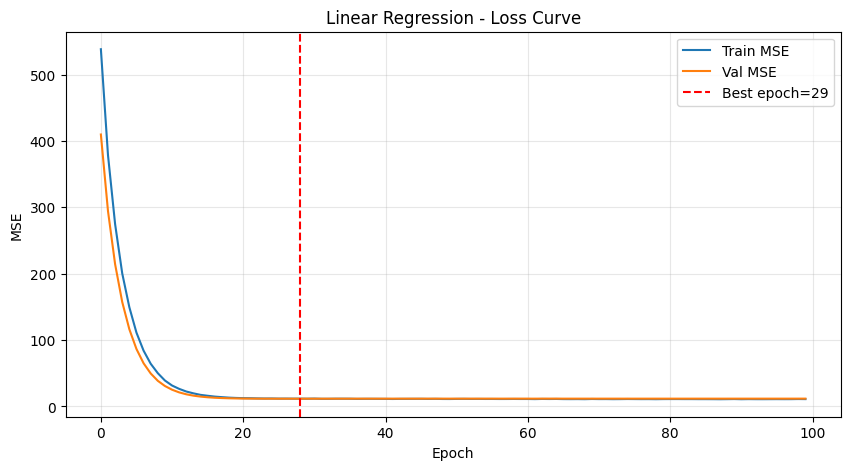

In [42]:
# Evaluate Linear Regression on test set and plot

if best_state is not None:
    lin.W, lin.b = best_state
    
    test_pred = lin.predict(x_test_s)
    test_loss = float(mse_loss(test_pred, y_test))
    print(f"Linear Regression - Test MSE: {test_loss:.4f}")
    
    plt.figure(figsize=(10, 5))
    plt.plot(lin_train_losses, label="Train MSE")
    plt.plot(lin_val_losses, label="Val MSE")
    plt.axvline(best_epoch - 1, linestyle="--", color="red", label=f"Best epoch={best_epoch}")
    plt.title("Linear Regression - Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No best state found. Please run training first.")


In [43]:
# Cell: Train MLP

epochs = 100
batch_size = 32
lr_mlp = 0.003

mlp = MLPRegressor(d_in=x_tr_s.shape[1], h1=64, h2=64, seed=42)

mlp_train_losses = []
mlp_val_losses = []

best_val_mlp = float("inf")
best_state_mlp = None
best_epoch_mlp = None

for epoch in range(1, epochs + 1):
    batch_losses = []
    for Xb, yb in make_batches(x_tr_s, y_tr, batch_size=batch_size, shuffle=True, seed=epoch):
        batch_losses.append(mlp.train_step(Xb, yb, lr=lr_mlp))
    train_loss = float(np.mean(batch_losses))

    val_pred = mlp.predict(x_val_s)
    val_loss = float(mse_loss(val_pred, y_val))

    mlp_train_losses.append(train_loss)
    mlp_val_losses.append(val_loss)

    if val_loss < best_val_mlp:
        best_val_mlp = val_loss
        best_state_mlp = (
            mlp.W1.copy(), mlp.b1.copy(),
            mlp.W2.copy(), mlp.b2.copy(),
            mlp.W3.copy(), mlp.b3.copy()
        )
        best_epoch_mlp = epoch

    if epoch == 1 or epoch % 10 == 0:
        print(f"[MLP] epoch {epoch:3d} | train={train_loss:.4f} | val={val_loss:.4f} | best={best_val_mlp:.4f} (ep {best_epoch_mlp})")

print("MLP best epoch:", best_epoch_mlp, "| best val:", best_val_mlp)
    

[MLP] epoch   1 | train=169.7790 | val=28.9059 | best=28.9059 (ep 1)
[MLP] epoch  10 | train=13.2424 | val=28.8419 | best=13.2300 (ep 8)
[MLP] epoch  20 | train=9.3918 | val=9.1562 | best=9.1562 (ep 20)
[MLP] epoch  30 | train=9.2050 | val=8.2180 | best=8.0834 (ep 28)
[MLP] epoch  40 | train=10.2134 | val=7.0430 | best=7.0430 (ep 40)
[MLP] epoch  50 | train=7.2115 | val=6.7531 | best=6.7232 (ep 49)
[MLP] epoch  60 | train=7.6380 | val=8.4459 | best=6.5585 (ep 54)
[MLP] epoch  70 | train=6.7393 | val=10.0999 | best=6.1399 (ep 67)
[MLP] epoch  80 | train=6.3942 | val=7.4272 | best=5.7704 (ep 75)
[MLP] epoch  90 | train=6.8878 | val=9.0123 | best=5.7704 (ep 75)
[MLP] epoch 100 | train=7.1072 | val=7.0456 | best=5.7704 (ep 75)
MLP best epoch: 75 | best val: 5.77044677734375


MLP Regression - Test MSE: 7.0814


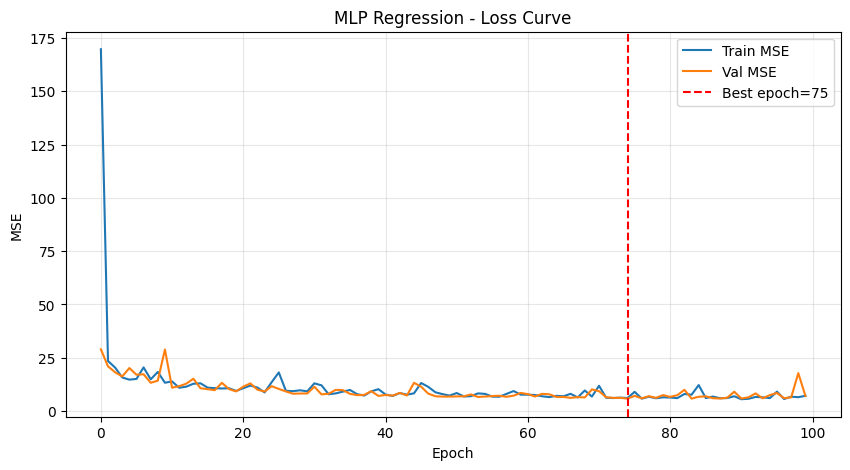

In [44]:
# Evaluate MLP on test set and plot

if best_state_mlp is not None:
    (mlp.W1, mlp.b1, mlp.W2, mlp.b2, mlp.W3, mlp.b3) = best_state_mlp
    
    test_pred = mlp.predict(x_test_s)
    test_loss = float(mse_loss(test_pred, y_test))
    print(f"MLP Regression - Test MSE: {test_loss:.4f}")
    
    plt.figure(figsize=(10, 5))
    plt.plot(mlp_train_losses, label="Train MSE")
    plt.plot(mlp_val_losses, label="Val MSE")
    plt.axvline(best_epoch_mlp - 1, linestyle="--", color="red", label=f"Best epoch={best_epoch_mlp}")
    plt.title("MLP Regression - Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No best state found. Please run MLP training first.")


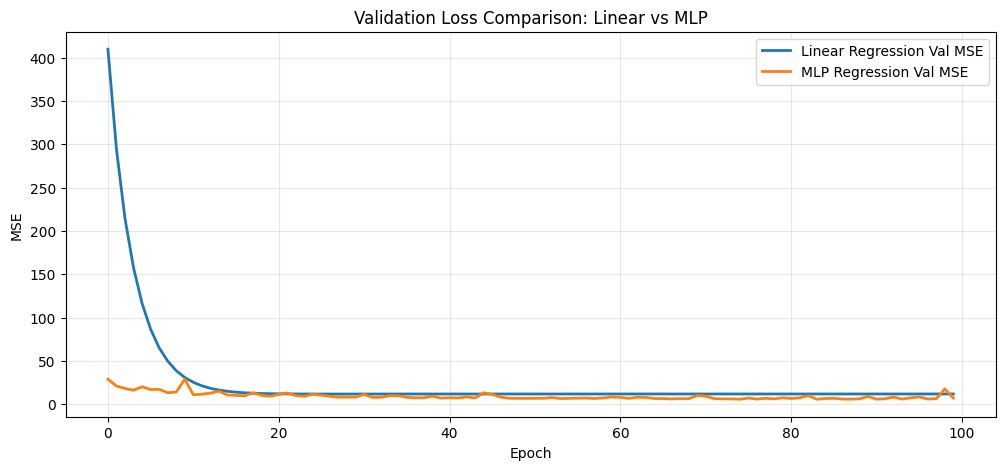


SUMMARY - Linear Regression
Best Val MSE: 11.7558 (epoch 29)
Test MSE: 11.7611

SUMMARY - MLP Regression
Best Val MSE: 5.7704 (epoch 75)
Test MSE: 7.0814

MLP improvement over Linear: 50.91%


In [45]:
# Compare Linear vs MLP performance

plt.figure(figsize=(12, 5))
plt.plot(lin_val_losses, label="Linear Regression Val MSE", linewidth=2)
plt.plot(mlp_val_losses, label="MLP Regression Val MSE", linewidth=2)
plt.title("Validation Loss Comparison: Linear vs MLP")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n" + "="*50)
print("SUMMARY - Linear Regression")
print("="*50)
print(f"Best Val MSE: {best_val:.4f} (epoch {best_epoch})")
if best_state is not None:
    lin_test_mse = float(mse_loss(lin.predict(x_test_s), y_test))
    print(f"Test MSE: {lin_test_mse:.4f}")

print("\n" + "="*50)
print("SUMMARY - MLP Regression")
print("="*50)
print(f"Best Val MSE: {best_val_mlp:.4f} (epoch {best_epoch_mlp})")
if best_state_mlp is not None:
    mlp_test_mse = float(mse_loss(mlp.predict(x_test_s), y_test))
    print(f"Test MSE: {mlp_test_mse:.4f}")
    
print("\n" + "="*50)
print(f"MLP improvement over Linear: {((best_val - best_val_mlp) / best_val * 100):.2f}%")


## Kết luận

### So sánh Linear Regression vs MLP Regression:

**Linear Regression:**
- Mô hình đơn giản, chỉ có 1 layer
- Best validation MSE: 11.76 (epoch 29)
- Test MSE: 11.76

**MLP Regression:**
- 2 hidden layers (64 nodes mỗi layer), activation ReLU
- Best validation MSE: 5.77 (epoch 75)
- Test MSE: 7.08
- **Cải thiện 50.91%** so với Linear Regression

### Nhận xét:
1. MLP cho kết quả tốt hơn đáng kể so với Linear Regression trên tập validation (~50% improvement)
2. MLP có khả năng học được các mối quan hệ phi tuyến trong dữ liệu
3. Test MSE của MLP cao hơn validation MSE một chút, cho thấy có overfitting nhẹ, nhưng vẫn tốt hơn Linear Regression nhiều
4. Linear Regression hội tụ nhanh hơn (~30 epochs) so với MLP (~75 epochs)
